In [41]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

from confidence_interval import calculate_confidence_interval, compare_model_accuracies

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

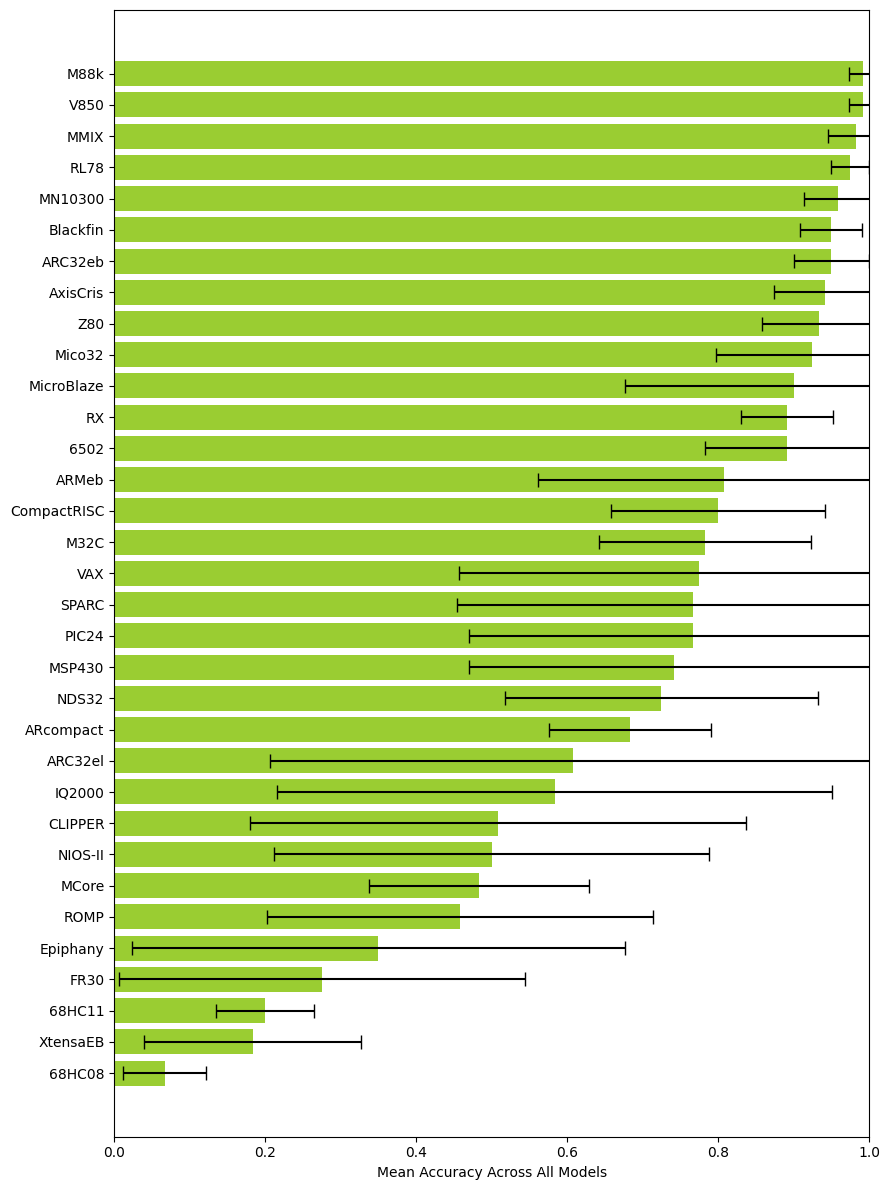

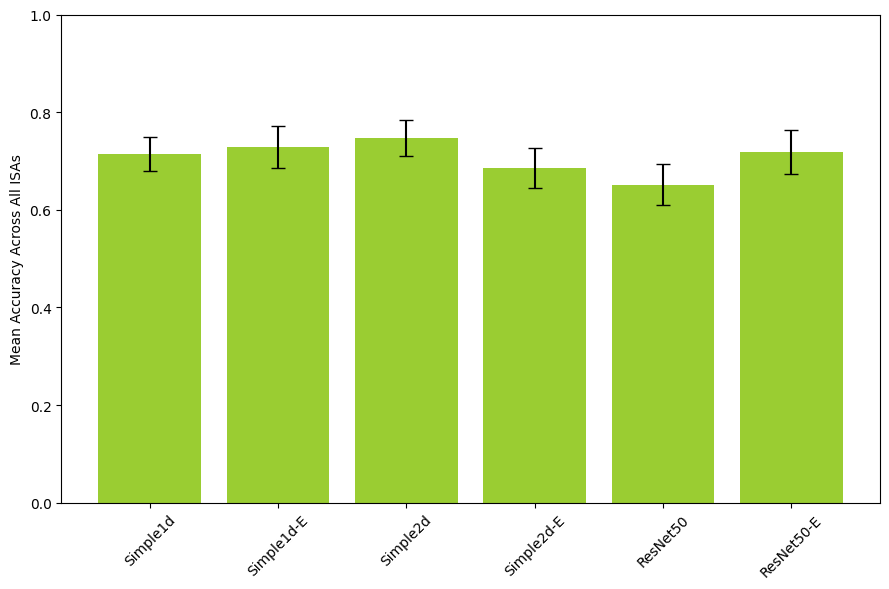

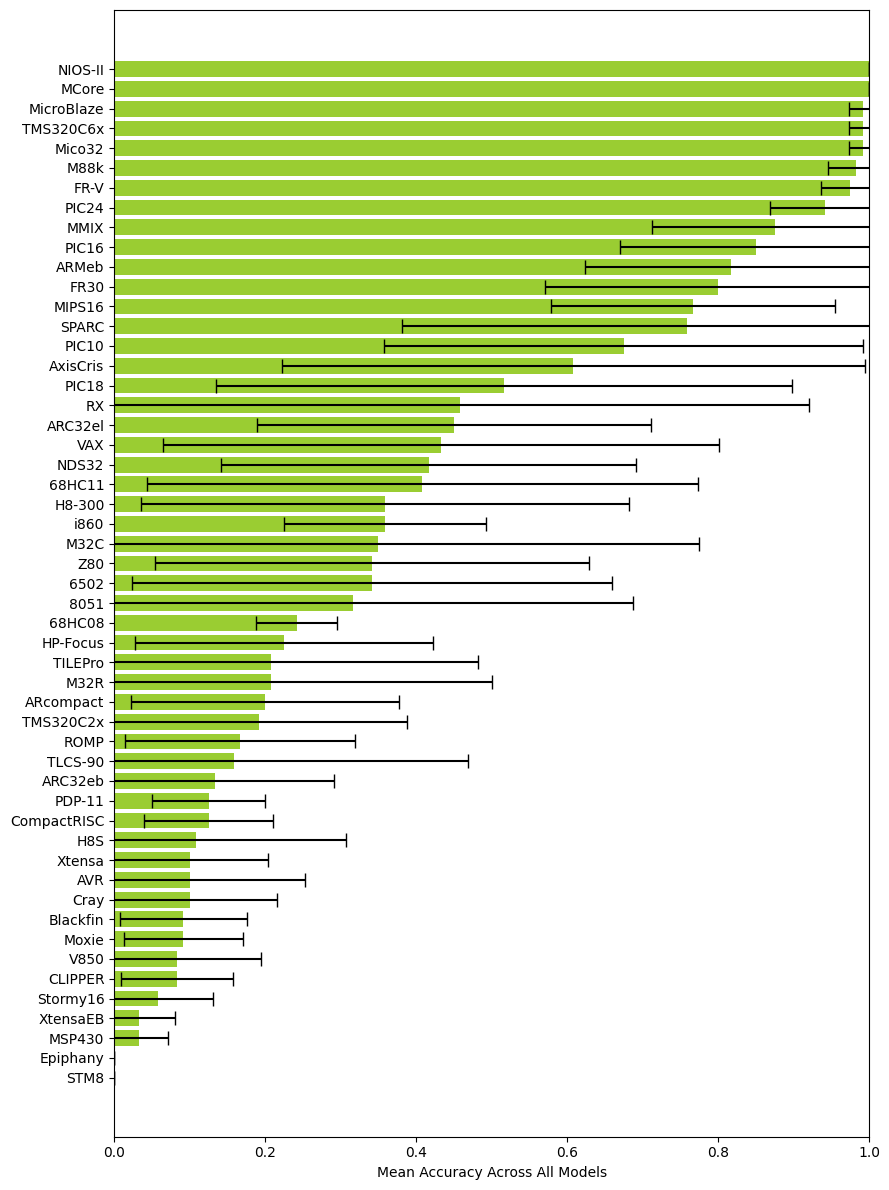

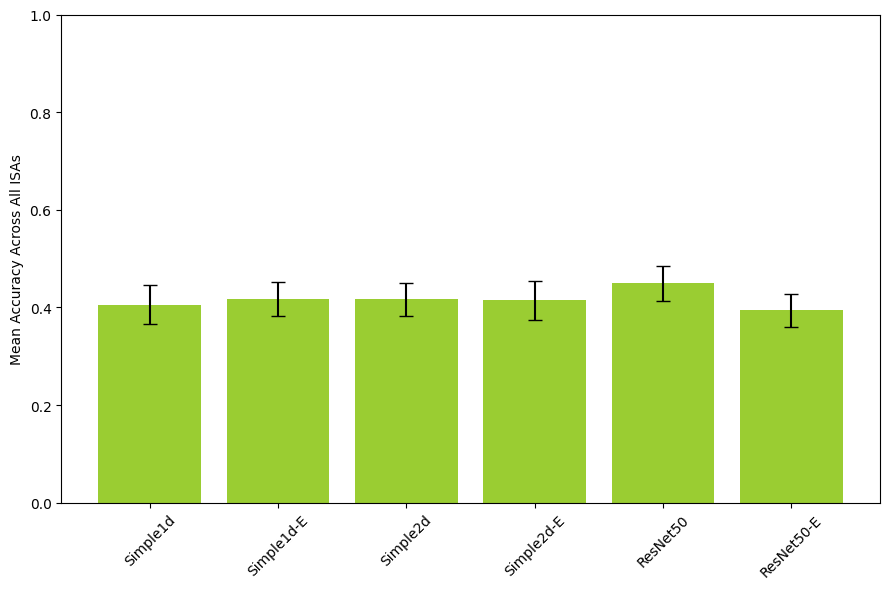

In [42]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "CpuRec-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    exclude_architectures = [
        "Alpha",
        "ARM64",
        "ARMel",
        "ARMhf",
        "HP-PA",
        "IA-64",
        "M68k",
        "MIPSeb",
        "MIPSel",
        "PPCeb",
        "PPCel",
        "RISC-V",
        "S-390",
        "SuperH",
        "X86-64",
        "X86",
    ]

    all_architectures -= set(exclude_architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Calculate the sum of all instance_count_* columns for each row
        samples_count_cols = [
            col for col in df.columns if col.startswith("instance_count_")
        ]
        df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)

        # Ensure all rows have the same total instance count
        assert (
            df["total_samples_count"] == df["total_samples_count"].iloc[0]
        ).all(), "Not all rows have the same samples count."

        samples_per_run = int(df["total_samples_count"].iloc[0])

        accuracies = []
        for _, row in df.iterrows():
            arch_weighted_accuracies = []
            total_instance_count = 0

            for architecture in all_architectures:
                if not math.isnan(row[f"test_accuracy_{architecture}"]):
                    arch_accurary = row[f"test_accuracy_{architecture}"]
                    arch_instance_count = row[f"instance_count_{architecture}"]
                    total_instance_count += arch_instance_count

                    arch_weighted_accuracies.append(arch_accurary * arch_instance_count)

            accuracies.append(np.sum(arch_weighted_accuracies) / total_instance_count)

        model_mean, model_conf_95, _, _ = calculate_confidence_interval(
            accuracies=accuracies, n_samples=samples_per_run, confidence=0.95
        )

        model_results[model_name] = (model_mean, model_conf_95)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()

            if not math.isnan(arch_mean):
                arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (ascending)
    sorted_architectures = sorted(
        arch_means.keys(), key=lambda x: arch_means[x], reverse=False
    )

    # Create horizontal bar chart aggregated by architecture
    plt.figure(figsize=(9, 12))
    arch_means_list = []
    arch_stds_list = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                arch_values.append(arch_model_results[arch][model][0])
        if arch_values:  # Only calculate if we have values
            arch_means_list.append(np.mean(arch_values))
            arch_stds_list.append(np.std(arch_values))

    bars = plt.barh(
        range(len(sorted_architectures)),
        arch_means_list,
        xerr=arch_stds_list,
        capsize=5,
        color="yellowgreen",
    )
    plt.yticks(range(len(sorted_architectures)), sorted_architectures)
    plt.xlabel("Mean Accuracy Across All Models")
    plt.xlim(0, 1)
    plt.tight_layout()
    # plt.savefig(
    #     f"output/cpurec-{target_feature.replace('_', '').lower()}-by-isa-exclude-overlap.png"
    # )

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_conf_95s = []

    for model in model_names:
        mean, conf_95 = model_results[model]
        model_means.append(mean)
        model_conf_95s.append(conf_95)

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_conf_95s,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All ISAs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/cpurec-{target_feature.replace('_', '').lower()}-by-model-exclude-overlap.png"
    )